In [46]:
import random
import pandas as pd
import numpy as np
import os
import librosa

import pickle

from tqdm.auto import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings(action='ignore') 

import argparse
import wandb
import torch
import torch.nn as nn

In [47]:
wandb.login()

True

In [48]:
%cd /workspace/EmotionShortForm/

/workspace/EmotionShortForm


In [49]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(41) # Seed 고정

## Train, Test 불러오기

In [50]:
# wav 파일의 mel Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv('preprocessing_csv/train_mfcc_data.csv')
test_df = pd.read_csv('preprocessing_csv/test_mfcc_data.csv')

## Preprocessing

+ target 변수가 너무 많고, neutral이 포함된 복합 감정 value가 많음
+ 복합 감정에 한해서만 neutral 변수 이름을 제거한 뒤 새로운 column 생성

['neutral', 'happy', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'happy', 'neutral', 'neutral', 'happy', 'neutral', 'neutral', 'angry', 'happy', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


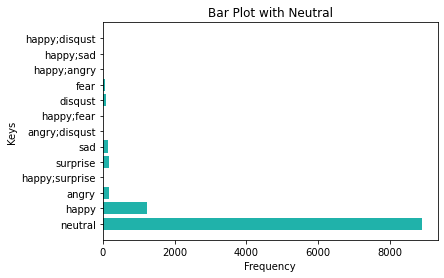

In [51]:
import matplotlib.pyplot as plt
import numpy as np

data_train = train_df["Emotion"]
data_test = test_df["Emotion"]

newEmotion_tr = [0]*train_df.shape[0]
newEmotion_te = [0]*test_df.shape[0]

for i in range(len(data_train)):
    if ';neutral' in data_train[i]: 
        new_emotion_lst = data_train[i].split(";neutral")
        new_emotion = "".join(new_emotion_lst)
        newEmotion_tr[i] = new_emotion
    elif 'neutral;' in data_train[i]: 
        new_emotion_lst = data_train[i].split("neutral;")
        new_emotion = "".join(new_emotion_lst)
        newEmotion_tr[i] = new_emotion
    else:
        newEmotion_tr[i]= data_train[i]


for i in range(len(data_test)):
    if ';neutral' in data_test[i]: 
        new_emotion_lst = data_test[i].split(";neutral")
        new_emotion = "".join(new_emotion_lst)
        newEmotion_te[i] = new_emotion
    elif 'neutral;' in data_test[i]: 
        new_emotion_lst = data_test[i].split("neutral;")
        new_emotion = "".join(new_emotion_lst)
        newEmotion_te[i] = new_emotion
    else:
        newEmotion_te[i]= data_test[i]

        
        

print(newEmotion_tr[:30])

counts = {}
for d in newEmotion_tr:
    if d in counts:
        counts[d] += 1
    else:
        counts[d] = 1

# Emotion별 원소 개수 확인
plt.barh(list(counts.keys()), list(counts.values()), color='lightseagreen')
plt.title('Bar Plot with Neutral')
plt.xlabel('Frequency')
plt.ylabel('Keys')

plt.show()



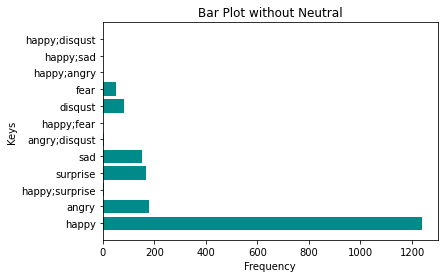

In [52]:
# neutral 제거 후 barplot
counts.pop("neutral")

plt.barh(list(counts.keys()), list(counts.values()), color='darkcyan')

# 그래프 제목과 레이블 추가
plt.title('Bar Plot without Neutral')
plt.xlabel('Frequency')
plt.ylabel('Keys')

plt.show()

In [53]:
newEmotion_tr_df = pd.DataFrame(newEmotion_tr, columns=['newEmotion'])
newEmotion_te_df = pd.DataFrame(newEmotion_te, columns=['newEmotion'])

## Train, Test df 생성
+ wav 파일의 mel feature과 상태 정보를 합친 학습데이터 생성

In [54]:
train_df = pd.concat([train_df, newEmotion_tr_df], axis=1)
test_df = pd.concat([test_df, newEmotion_te_df], axis=1)

train_df = train_df.drop(['Emotion'], axis=1)
test_df = test_df.drop(['Emotion'], axis=1)

In [55]:
print(train_df.shape)
print(test_df.shape)

(10769, 38)
(2693, 38)


In [56]:
train_df.dropna()
test_df.dropna()

,Unnamed: 0,SegmentId,time,Valence,Arousal,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,mfcc_24,mfcc_25,mfcc_26,mfcc_27,mfcc_28,mfcc_29,mfcc_30,mfcc_31,mfcc_32,newEmotion
0,63,Sess13_script01_User026F_029,7.254990,3.7,3.5,-336.985138,106.803337,4.534938,10.542789,-19.378389,...,8.967966,8.074034,11.653221,11.598641,8.817598,9.400865,8.987887,5.992146,4.622094,happy
1,5163,Sess03_script03_User005M_021,2.212000,2.9,3.4,-337.904297,105.446899,11.310282,24.076952,-6.819501,...,-4.050204,-3.444622,-0.045880,-2.624972,-0.375320,-1.709600,-1.171931,-4.099090,-1.587989,surprise
2,7844,Sess23_script02_User046M_022,9.281020,2.3,3.0,-419.555511,125.555763,18.391697,30.752876,-5.573301,...,-3.478583,-2.749439,1.098240,1.010692,0.460480,-1.992547,1.084825,-0.576132,0.662649,neutral
3,304,Sess13_script05_User026F_017,6.614991,4.4,4.2,-261.221222,108.892136,-26.196730,9.421447,-25.387993,...,13.833956,7.379666,8.362466,1.706965,5.596114,5.339090,5.811155,1.621077,3.745970,happy
4,5216,Sess03_script04_User005M_008,3.404998,1.6,3.2,-346.095032,101.206184,21.618317,20.990105,-11.223962,...,-0.532429,-1.102016,1.010110,-1.844896,-1.788239,0.140551,-2.089751,-1.204731,-1.450962,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2688,8873,Sess39_script05_User078F_007,4.404998,3.0,3.0,-452.831024,80.856758,19.427954,32.913322,-3.974150,...,1.763288,2.534321,1.811994,4.191569,6.094894,5.072481,7.664765,4.959315,4.205091,neutral
2689,11974,Sess37_script05_User073F_012,6.781000,2.6,3.2,-450.678375,98.769257,-4.727075,7.584974,-11.716160,...,3.983363,4.685560,2.902997,0.235584,2.744654,1.443039,5.997917,3.257085,5.762399,neutral
2690,10559,Sess33_script04_User065M_028,3.066020,3.4,3.4,-371.517609,117.556679,5.498871,27.535383,7.929699,...,-1.782557,-2.510203,-2.095202,-3.341051,-1.580801,-0.980542,0.799156,-2.367372,0.982645,neutral
2691,3076,Sess02_script02_User003F_001,12.123001,2.4,2.6,-375.577759,106.716896,2.852894,26.215828,-20.312307,...,4.127676,8.754350,5.358984,4.600071,9.529908,5.941333,14.158734,8.534500,10.391392,neutral


### labeling 다시 (감정 레이블 7개만 사용)

In [57]:
condition = (
    (train_df.newEmotion == 'neutral') |
    (train_df.newEmotion == 'happy')|
    (train_df.newEmotion == 'angry') |
    (train_df.newEmotion == 'surprise') |
    (train_df.newEmotion == 'sad') |
    (train_df.newEmotion == 'disqust')|
    (train_df.newEmotion == 'fear')
)

train_df = train_df.loc[condition]
train_df = train_df.reset_index(drop=True)

In [58]:
condition = (
    (test_df.newEmotion == 'neutral') |
    (test_df.newEmotion == 'happy')|
    (test_df.newEmotion == 'angry') |
    (test_df.newEmotion == 'surprise') |
    (test_df.newEmotion == 'sad') |
    (test_df.newEmotion == 'disqust')|
    (test_df.newEmotion == 'fear')
)

test_df = test_df.loc[condition]
test_df = test_df.reset_index(drop=True)

In [59]:
print(train_df.shape)
print(test_df.shape)

(10754, 38)
(2686, 38)


In [60]:
train_df['newEmotion'] = train_df['newEmotion'].replace(['neutral',
                                                         'happy',
                                                         'angry',
                                                         'surprise',
                                                         'sad',
                                                         'disqust',
                                                         'fear'],
                                                        [0,1,2,3,4,5,6])

In [61]:
test_df['newEmotion'] = test_df['newEmotion'].replace(['neutral',
                                                         'happy',
                                                         'angry',
                                                         'surprise',
                                                         'sad',
                                                         'disqust',
                                                         'fear'
                                                      ],[0,1,2,3,4,5,6])

## neutral 데이터 개수 줄이기 knn

In [62]:
train_df.shape

(10754, 38)

In [63]:
import numpy as np

# train 데이터셋에서 중립 데이터 개수 줄이기
neutral_indices = np.where(train_df['newEmotion'] == 0)[0]

# # 중립 데이터 중 일부를 삭제
num_to_delete = 5000
delete_indices = np.random.choice(neutral_indices, size=num_to_delete, replace=False)
#print(delete_indices.shape)
# # 추출한 인덱스를 사용하여 중립 데이터를 삭제합니다.
#print(train_df.shape)
train_df = train_df.drop(delete_indices, axis=0)
print(train_df.shape)
# label_array = np.delete(label_array, delete_indices, axis=0)

(5754, 38)


In [64]:
## test 데이터 중립 데이터 개수 줄이기
neutral_indices = np.where(test_df['newEmotion'] == 0)[0] # 인덱스 추출

# # 중립 데이터 중 일부를 삭제
num_to_delete = 1000 
delete_indices = np.random.choice(neutral_indices, size=num_to_delete, replace=False)
#print(delete_indices.shape)
# # 추출한 인덱스를 사용하여 중립 데이터를 삭제합니다.
#print(train_df.shape)
test_df = test_df.drop(delete_indices, axis=0)
print(test_df.shape)
# label_array = np.delete(label_array, delete_indices, axis=0)

(1686, 38)


## check sample ratio + oversampling

In [65]:
train_df['newEmotion'].value_counts()

0    3880
1    1237
2     180
3     169
4     154
5      81
6      53
Name: newEmotion, dtype: int64

In [66]:
test_df['newEmotion'].value_counts()

0    1240
1     291
2      47
3      43
4      38
5      20
6       7
Name: newEmotion, dtype: int64

In [67]:
# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
train_x = train_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','newEmotion'])
train_y = train_df['newEmotion']
test_x = test_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','newEmotion'])
test_y = test_df['newEmotion']

Text(0, 0.5, 'Number of Samples')

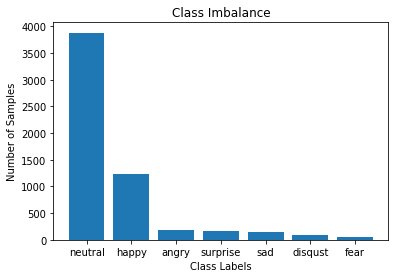

In [68]:
import matplotlib.pyplot as plt
labels =['neutral', 'happy','angry','surprise','sad','disqust','fear']
counts = train_y.value_counts().tolist()
# 그래프 그리기
plt.bar(labels, counts)

# 그래프 타이틀, 라벨 등 설정
plt.title('Class Imbalance')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

## Trial 1. SMOTE (Oversampling)

In [96]:
from imblearn.over_sampling import SMOTE

sm=SMOTE(k_neighbors=2, random_state=0) #same size of the training data set as random over sampling
X_train_resampled_sm, Y_train_resampled_sm = sm.fit_resample(train_x,train_y)
X_test_resampled_sm, Y_test_resampled_sm = sm.fit_resample(test_x,test_y)

Text(0, 0.5, 'Number of Samples')

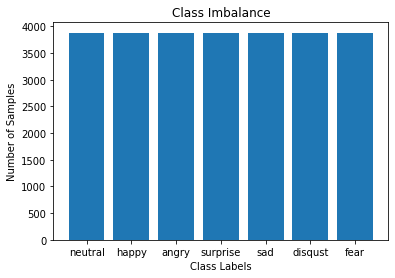

In [97]:
import matplotlib.pyplot as plt
labels =['neutral', 'happy','angry','surprise','sad','disqust','fear']
counts = Y_train_resampled_sm.value_counts().tolist()
# 그래프 그리기
plt.bar(labels, counts)

# 그래프 타이틀, 라벨 등 설정
plt.title('Class Imbalance')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

In [98]:
Y_train_resampled_sm.value_counts()

6    3880
5    3880
4    3880
3    3880
2    3880
1    3880
0    3880
Name: newEmotion, dtype: int64

In [99]:
# Y_test_resampled_sm.value_counts()

In [100]:
X_train_resampled_sm.shape

(27160, 32)

In [101]:
X_train_resampled_sm = torch.from_numpy(X_train_resampled_sm.to_numpy()).float()
Y_train_resampled_sm = torch.tensor(Y_train_resampled_sm)

In [102]:
X_train_resampled_sm.shape

torch.Size([27160, 32])

In [103]:
X_test_resampled_sm = torch.from_numpy(X_test_resampled_sm.to_numpy()).float()
Y_test_resampled_sm = torch.tensor(Y_test_resampled_sm)

# LSTM model

In [126]:
wandb.init(project="EmotionShortForm")

In [127]:
parser = argparse.ArgumentParser(description="Baseline")
parser.add_argument('--optimizer', default="adam", type=str) # sgd or adam
parser.add_argument('--loss', default="fl", type=str) # bc or fl or fl_af
parser.add_argument('--learning_rate', default=0.001, type=float)
parser.add_argument('--epochs', default=1500, type=int)
parser.add_argument('--input_size', default=32, type=int) # 130
parser.add_argument('--hidden_size', default=128, type=int)
parser.add_argument('--output_size', default=7, type=int)
parser.add_argument('--num_layers', default=3, type=int)
args = parser.parse_args('')

wandb.config.update(args)

In [128]:
optimizer = args.optimizer
loss = args.loss
learning_rate = args.learning_rate
EPOCHS = args.epochs
input_size= args.input_size # number of input data size
hidden_size=args.hidden_size
output_size = args.output_size
num_layers = args.num_layers

In [129]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,  dropout_rate = 0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))

        output = self.fc(out[:,-1,:])
        hidden = self.fc(hidden_state[-1])
        output = F.softmax(output,dim=1) 
        return output, hidden,  out[:,-1,:]

## Define Model, Criterion, Optimizer

In [130]:
import torch.nn.functional as F


model=LSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss, BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

## Training

In [132]:
# dropout 적용
from tqdm.notebook import tqdm

wandb.init(project="EmotionShortForm", 
           name="20230420_1",
          )

Y_train_resampled_sm = Y_train_resampled_sm.long()
min_f1=0
for epoch in tqdm(range(EPOCHS), desc='Training', unit='epoch'):
    optimizer.zero_grad()

    model.train()
    
    # Forward pass with dropout
    X_train_resampled_sm_drop = nn.Dropout(p=0.5)(X_train_resampled_sm.unsqueeze(1))
    output, hidden_state, _ = model(X_train_resampled_sm_drop)
    #print(f"output: {output.squeeze().shape}")
    #print(f"Y_train_resampled_sm: {Y_train_resampled_sm.shape}")
    # Compute loss
    loss = criterion(output.squeeze(), Y_train_resampled_sm)
    wandb.log({
    'Oversampling_Train_Loss': loss.item()
    })

    # Backward and optimize
    loss.backward()
    optimizer.step()
    tqdm.write('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, EPOCHS, loss.item()))
    
    model.eval()
    with torch.no_grad():
        predictions, hidden, out = model(X_test_resampled_sm.unsqueeze(1))
        y_pred = predictions.argmax(dim=1)

        f1 = f1_score(Y_test_resampled_sm, y_pred, average='macro')
        if f1 > min_f1:
            min_f1 = f1
            print(f'min_f1: {min_f1}') 
            torch.save(model.state_dict(), f'./model/lstm_emotion_classification_model_best.pt')
   
    
   
wandb.finish()

Training:   0%|          | 0/1500 [00:00<?, ?epoch/s]

Epoch [1/1500], Loss: 1.9459
min_f1: 0.03571428571428571
Epoch [2/1500], Loss: 1.9459
Epoch [3/1500], Loss: 1.9459
Epoch [4/1500], Loss: 1.9458
Epoch [5/1500], Loss: 1.9458
Epoch [6/1500], Loss: 1.9458
min_f1: 0.035717886307663496
Epoch [7/1500], Loss: 1.9457
min_f1: 0.03833774245734478
Epoch [8/1500], Loss: 1.9457
min_f1: 0.057694539527592924
Epoch [9/1500], Loss: 1.9457
min_f1: 0.08739525779359157
Epoch [10/1500], Loss: 1.9456
min_f1: 0.11262118848221322
Epoch [11/1500], Loss: 1.9455
min_f1: 0.1287965681220893
Epoch [12/1500], Loss: 1.9455
min_f1: 0.1448438554286398
Epoch [13/1500], Loss: 1.9454
min_f1: 0.15040204717997566
Epoch [14/1500], Loss: 1.9453
Epoch [15/1500], Loss: 1.9452
Epoch [16/1500], Loss: 1.9450
Epoch [17/1500], Loss: 1.9449
min_f1: 0.16443062657838886
Epoch [18/1500], Loss: 1.9447
min_f1: 0.17528056147210805
Epoch [19/1500], Loss: 1.9445
Epoch [20/1500], Loss: 1.9442
Epoch [21/1500], Loss: 1.9438
Epoch [22/1500], Loss: 1.9434
Epoch [23/1500], Loss: 1.9430
Epoch [24/1

Epoch [223/1500], Loss: 1.7933
Epoch [224/1500], Loss: 1.7913
Epoch [225/1500], Loss: 1.7924
Epoch [226/1500], Loss: 1.7897
Epoch [227/1500], Loss: 1.7933
min_f1: 0.3467201534035258
Epoch [228/1500], Loss: 1.7917
min_f1: 0.3485237235219706
Epoch [229/1500], Loss: 1.7910
min_f1: 0.3517307213293365
Epoch [230/1500], Loss: 1.7923
Epoch [231/1500], Loss: 1.7903
Epoch [232/1500], Loss: 1.7896
Epoch [233/1500], Loss: 1.7905
Epoch [234/1500], Loss: 1.7870
Epoch [235/1500], Loss: 1.7910
Epoch [236/1500], Loss: 1.7877
Epoch [237/1500], Loss: 1.7880
Epoch [238/1500], Loss: 1.7892
Epoch [239/1500], Loss: 1.7899
Epoch [240/1500], Loss: 1.7872
Epoch [241/1500], Loss: 1.7817
Epoch [242/1500], Loss: 1.7851
Epoch [243/1500], Loss: 1.7876
Epoch [244/1500], Loss: 1.7843
Epoch [245/1500], Loss: 1.7842
Epoch [246/1500], Loss: 1.7839
Epoch [247/1500], Loss: 1.7840
Epoch [248/1500], Loss: 1.7871
Epoch [249/1500], Loss: 1.7870
Epoch [250/1500], Loss: 1.7827
Epoch [251/1500], Loss: 1.7858
Epoch [252/1500], Lo

Epoch [482/1500], Loss: 1.7552
Epoch [483/1500], Loss: 1.7538
Epoch [484/1500], Loss: 1.7494
Epoch [485/1500], Loss: 1.7515
Epoch [486/1500], Loss: 1.7550
Epoch [487/1500], Loss: 1.7535
Epoch [488/1500], Loss: 1.7531
Epoch [489/1500], Loss: 1.7536
Epoch [490/1500], Loss: 1.7539
Epoch [491/1500], Loss: 1.7567
Epoch [492/1500], Loss: 1.7560
Epoch [493/1500], Loss: 1.7566
Epoch [494/1500], Loss: 1.7532
Epoch [495/1500], Loss: 1.7550
Epoch [496/1500], Loss: 1.7575
Epoch [497/1500], Loss: 1.7507
Epoch [498/1500], Loss: 1.7534
Epoch [499/1500], Loss: 1.7503
Epoch [500/1500], Loss: 1.7532
Epoch [501/1500], Loss: 1.7526
Epoch [502/1500], Loss: 1.7549
Epoch [503/1500], Loss: 1.7557
Epoch [504/1500], Loss: 1.7532
Epoch [505/1500], Loss: 1.7529
Epoch [506/1500], Loss: 1.7538
Epoch [507/1500], Loss: 1.7542
Epoch [508/1500], Loss: 1.7518
Epoch [509/1500], Loss: 1.7534
Epoch [510/1500], Loss: 1.7557
Epoch [511/1500], Loss: 1.7538
Epoch [512/1500], Loss: 1.7489
Epoch [513/1500], Loss: 1.7525
Epoch [5

Epoch [744/1500], Loss: 1.7396
Epoch [745/1500], Loss: 1.7371
Epoch [746/1500], Loss: 1.7425
Epoch [747/1500], Loss: 1.7451
Epoch [748/1500], Loss: 1.7426
Epoch [749/1500], Loss: 1.7415
Epoch [750/1500], Loss: 1.7421
Epoch [751/1500], Loss: 1.7392
Epoch [752/1500], Loss: 1.7413
Epoch [753/1500], Loss: 1.7408
Epoch [754/1500], Loss: 1.7399
Epoch [755/1500], Loss: 1.7419
Epoch [756/1500], Loss: 1.7385
Epoch [757/1500], Loss: 1.7402
Epoch [758/1500], Loss: 1.7405
Epoch [759/1500], Loss: 1.7458
Epoch [760/1500], Loss: 1.7402
Epoch [761/1500], Loss: 1.7368
Epoch [762/1500], Loss: 1.7416
Epoch [763/1500], Loss: 1.7378
Epoch [764/1500], Loss: 1.7390
Epoch [765/1500], Loss: 1.7442
Epoch [766/1500], Loss: 1.7398
Epoch [767/1500], Loss: 1.7351
Epoch [768/1500], Loss: 1.7398
Epoch [769/1500], Loss: 1.7392
Epoch [770/1500], Loss: 1.7388
Epoch [771/1500], Loss: 1.7393
Epoch [772/1500], Loss: 1.7380
Epoch [773/1500], Loss: 1.7425
Epoch [774/1500], Loss: 1.7374
Epoch [775/1500], Loss: 1.7406
Epoch [7

Epoch [1004/1500], Loss: 1.7324
Epoch [1005/1500], Loss: 1.7333
Epoch [1006/1500], Loss: 1.7316
Epoch [1007/1500], Loss: 1.7270
Epoch [1008/1500], Loss: 1.7301
Epoch [1009/1500], Loss: 1.7300
Epoch [1010/1500], Loss: 1.7323
Epoch [1011/1500], Loss: 1.7299
Epoch [1012/1500], Loss: 1.7297
Epoch [1013/1500], Loss: 1.7342
Epoch [1014/1500], Loss: 1.7318
Epoch [1015/1500], Loss: 1.7294
Epoch [1016/1500], Loss: 1.7305
Epoch [1017/1500], Loss: 1.7278
Epoch [1018/1500], Loss: 1.7269
Epoch [1019/1500], Loss: 1.7297
Epoch [1020/1500], Loss: 1.7304
Epoch [1021/1500], Loss: 1.7289
Epoch [1022/1500], Loss: 1.7322
Epoch [1023/1500], Loss: 1.7304
Epoch [1024/1500], Loss: 1.7321
Epoch [1025/1500], Loss: 1.7287
Epoch [1026/1500], Loss: 1.7309
Epoch [1027/1500], Loss: 1.7304
Epoch [1028/1500], Loss: 1.7319
Epoch [1029/1500], Loss: 1.7269
Epoch [1030/1500], Loss: 1.7293
Epoch [1031/1500], Loss: 1.7295
Epoch [1032/1500], Loss: 1.7330
Epoch [1033/1500], Loss: 1.7330
Epoch [1034/1500], Loss: 1.7297
Epoch [1

Epoch [1256/1500], Loss: 1.7226
Epoch [1257/1500], Loss: 1.7264
Epoch [1258/1500], Loss: 1.7245
Epoch [1259/1500], Loss: 1.7250
Epoch [1260/1500], Loss: 1.7286
Epoch [1261/1500], Loss: 1.7240
Epoch [1262/1500], Loss: 1.7277
Epoch [1263/1500], Loss: 1.7244
Epoch [1264/1500], Loss: 1.7230
Epoch [1265/1500], Loss: 1.7227
Epoch [1266/1500], Loss: 1.7233
Epoch [1267/1500], Loss: 1.7271
Epoch [1268/1500], Loss: 1.7272
Epoch [1269/1500], Loss: 1.7279
Epoch [1270/1500], Loss: 1.7228
Epoch [1271/1500], Loss: 1.7225
Epoch [1272/1500], Loss: 1.7257
Epoch [1273/1500], Loss: 1.7263
Epoch [1274/1500], Loss: 1.7252
Epoch [1275/1500], Loss: 1.7281
Epoch [1276/1500], Loss: 1.7251
Epoch [1277/1500], Loss: 1.7260
Epoch [1278/1500], Loss: 1.7250
Epoch [1279/1500], Loss: 1.7250
Epoch [1280/1500], Loss: 1.7255
Epoch [1281/1500], Loss: 1.7272
Epoch [1282/1500], Loss: 1.7223
Epoch [1283/1500], Loss: 1.7259
Epoch [1284/1500], Loss: 1.7231
Epoch [1285/1500], Loss: 1.7231
Epoch [1286/1500], Loss: 1.7244
Epoch [1

Oversampling_Train_Loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Oversampling_Train_Loss,1.72147


## Model Evaluation

In [133]:
model = LSTM(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('./model/lstm_emotion_classification_model_best.pt'))

<All keys matched successfully>

In [134]:
model.eval()
with torch.no_grad():
    train_predict,target_hidden,_ = model(X_train_resampled_sm.unsqueeze(1))
    test_predict,test_hidden,_ = model(X_test_resampled_sm.unsqueeze(1))
    train_loss = criterion(train_predict, Y_train_resampled_sm)
    test_loss = criterion(test_predict, Y_test_resampled_sm)
    print('Train Loss: {:.4f}'.format(train_loss.item()))
    print('Test Loss: {:.4f}'.format(test_loss.item()))
    ## oversampling 문제 발생
    
    '''
    1)
    dropout했을 때 + smote
    epoch: 500
    Train Loss: 1.2529
    Test Loss: 2.0355
    2) 
    dropout했을 때 + smote
    epoch: 700
    Train Loss: 1.0857
Test Loss: 2.1099

    3) 
    dropout + neutral데이터 4000개 줄임
    epoch: 700
    Train Loss: 0.6769
    Test Loss: 2.0612
    
    4) 
     dropout + neutral데이터 Train 5000, test 1000개 줄임
    Train Loss: 0.7101
    Test Loss: 1.9471
    
    Train Loss: 1.1158
    Test Loss: 1.7357
    
    
    '''

Train Loss: 1.5798
Test Loss: 1.7537


In [135]:
from torch.utils.data import DataLoader, TensorDataset

validation_set = TensorDataset(X_test_resampled_sm, Y_test_resampled_sm)
validation_loader = DataLoader(validation_set, shuffle=False)

In [136]:
model.eval()  # set model to evaluation mode

with torch.no_grad(): # temporarily disable gradient calculation for efficiency
    
    correct = 0
    total = 0
    
    for data in validation_loader:
        
        inputs, labels = data
        inputs = inputs.unsqueeze(1) # add an extra dimension for the sequence length
        #print(inputs.shape)
        outputs,outputs_hidden,_ = model(inputs)
        #print(outputs.data)
        _, predicted = torch.max(outputs.data, 1) # get the index of the max log-probability
        total += labels.size(0)
        #print(f'predicted: {predicted}, label_size: {labels.size(0)}, labels: {labels}')
        
        correct += (predicted == labels).sum().item()
        
    accuracy = 100 * correct / total
    print('Accuracy on validation set: {:.2f}%'.format(accuracy))
    
'''
800 epoch
Accuracy on validation set: 38.56%'''

Accuracy on validation set: 40.84%


'\n800 epoch\nAccuracy on validation set: 38.56%'

### F1 score

In [137]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()
with torch.no_grad():
    predictions, hidden, out = model(X_test_resampled_sm.unsqueeze(1))
    
    y_pred = predictions.argmax(dim=1)
    
#     lstm_feature = model.fc(model.hidden.squeeze())
    
    precision = precision_score(Y_test_resampled_sm, y_pred, average='macro')
    recall = recall_score(Y_test_resampled_sm, y_pred, average='macro')
    f1 = f1_score(Y_test_resampled_sm, y_pred, average='macro')
    print('Y_test_resampled_sm: \n' , Y_test_resampled_sm)
    print('y_pred: \n', y_pred)
    print('=============================')
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 score:', f1)
    print('Predictions: ', y_pred)
    print(f'Extracting 128 sized features: {out.shape}') # 128 sized feature 
#     print(f'shape: {out.shape}')


    '''
    1)
    dropout + smote 
    epoch:500
    Precision: 0.3007015306122449
    Recall: 0.3007015306122449
    F1 score: 0.3007015306122449
    2)
    dropout했을 때 + smote
    epoch: 700
    Precision: 0.30031887755102044
    Recall: 0.30031887755102044
    F1 score: 0.30031887755102044
    3) 
 중립 데이터 4000개 줄였을 때
     Precision: 0.31868622448979594
    Recall: 0.31868622448979594
    F1 score: 0.31868622448979594
    
    4)   dropout + neutral데이터 Train 5000, test 1000개 줄임
    Precision: 0.3968933771621839
    Recall: 0.3768433179723502
    F1 score: 0.3662198839219138
    
    5) 800 epoch
    Precision: 0.42570893934757414
Recall: 0.3855990783410138
F1 score: 0.3747435795726259


6) 1000 epoch 
Accuracy on validation set: 39.61%
Precision: 0.4147809657621006
Recall: 0.39608294930875576
F1 score: 0.3872494008185158




    '''

Y_test_resampled_sm: 
 tensor([1, 3, 1,  ..., 6, 6, 6])
y_pred: 
 tensor([2, 0, 1,  ..., 4, 6, 5])
Precision: 0.4242735529760329
Recall: 0.4084101382488479
F1 score: 0.39676196178417117
Predictions:  tensor([2, 0, 1,  ..., 4, 6, 5])
Extracting 128 sized features: torch.Size([8680, 128])


## Model save

In [112]:
# import pickle
# filename = './model/lstm_emotion_classification_model.pkl'
# pickle.dump(model, open(filename,'wb'))

# Save model
import torch

torch.save(model.state_dict(), './model/lstm_emotion_classification_model.pt')